# Import modules

In [73]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# from tqdm import tqdm
# import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
# from src.helper_text import *
# from src.helper_langID import *
# from src.helper_translation import *
from src.helper_pred import *

# Prepare Data

## Load Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106895 entries, 0 to 106894
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        106895 non-null  int64 
 1   Title             106895 non-null  object
 2   Product Name      106895 non-null  object
 3   Length            106895 non-null  int64 
 4   Language          106895 non-null  object
 5   Title_Processed   106895 non-null  object
 6   Title_Translated  106895 non-null  object
 7   Title_Cleaned     106895 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11878 entries, 0 to 11877
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        11878 non-null  int64 
 1   Title             11878 non-null  object
 2   Product Name      11878 non-null  object
 3   Length            1187

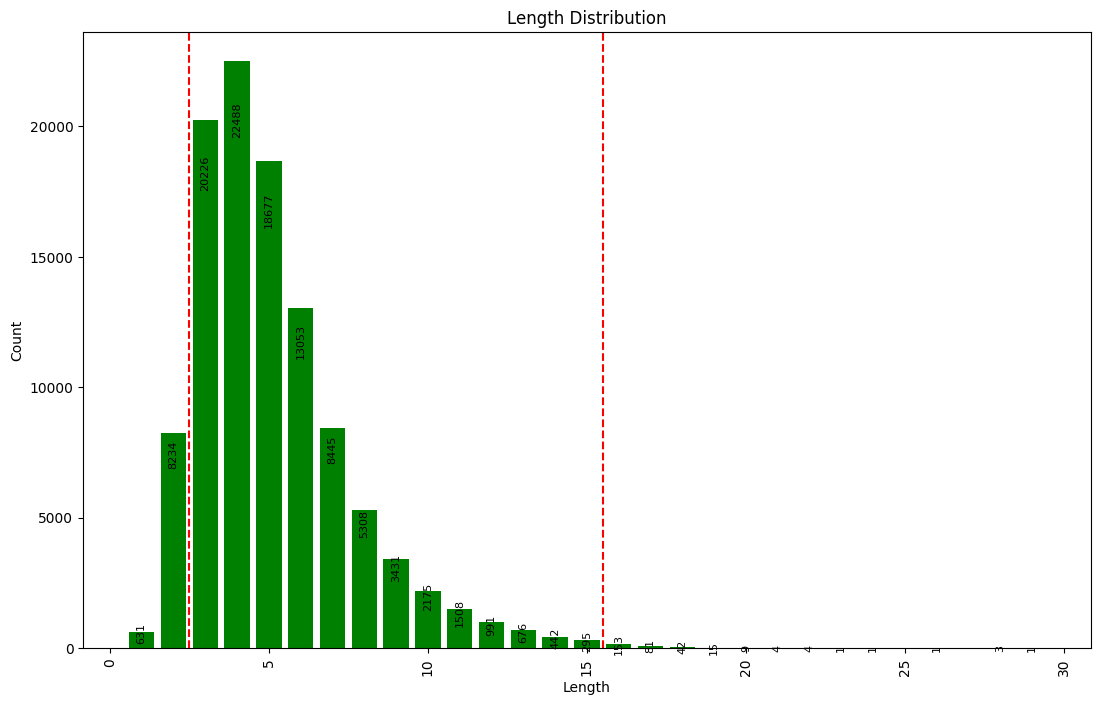

In [74]:
# excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
df_train = pd.read_excel(excel_file)
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
df_test = pd.read_excel(excel_file_test)

print(df_train.info())
print(df_test.info())
hist_by_labels(df_train, 'Length', log=False, left=2.5, right=15.5)
# plot a square in red color on the histogram

## Remove short Titles

/var/folders/r4/9ch2b93x7yd208vwqjxkx9180000gn/T/ipykernel_17711/2834626255.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[mask]


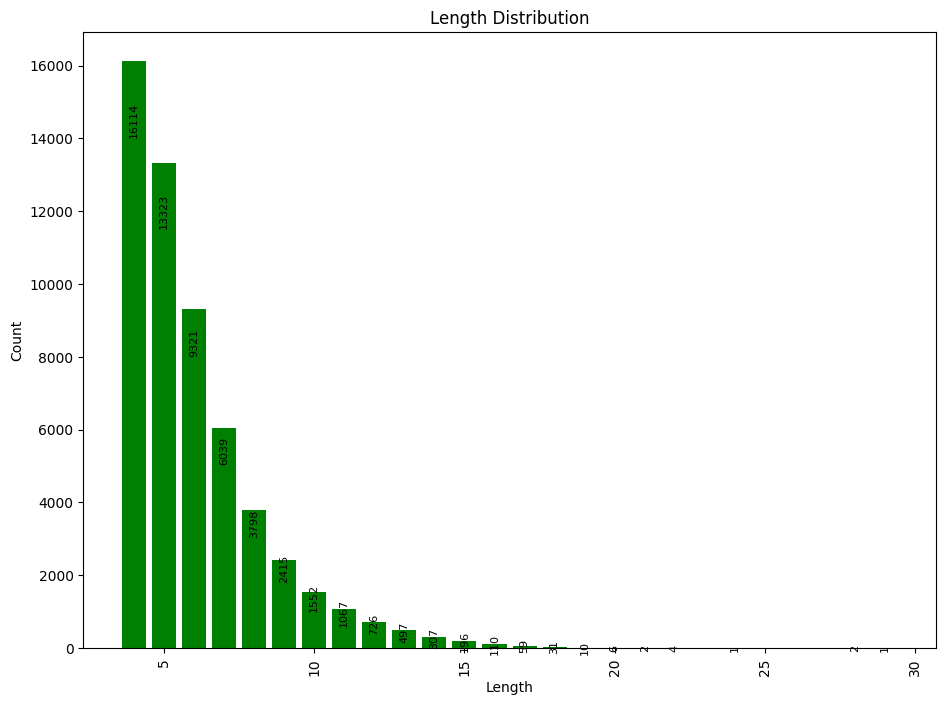

In [75]:
# filter out the titles with length less than 3 and more than 20
# when the title is too short, it is either not useful or it is too obvious to be classified
mask = (df_train['Length'] > 3) & (df_cleaned['Length'] < 20)
df_train = df_train[mask]
hist_by_labels(df_train, 'Length', horizontal=True)

## Combine the long tail into Others

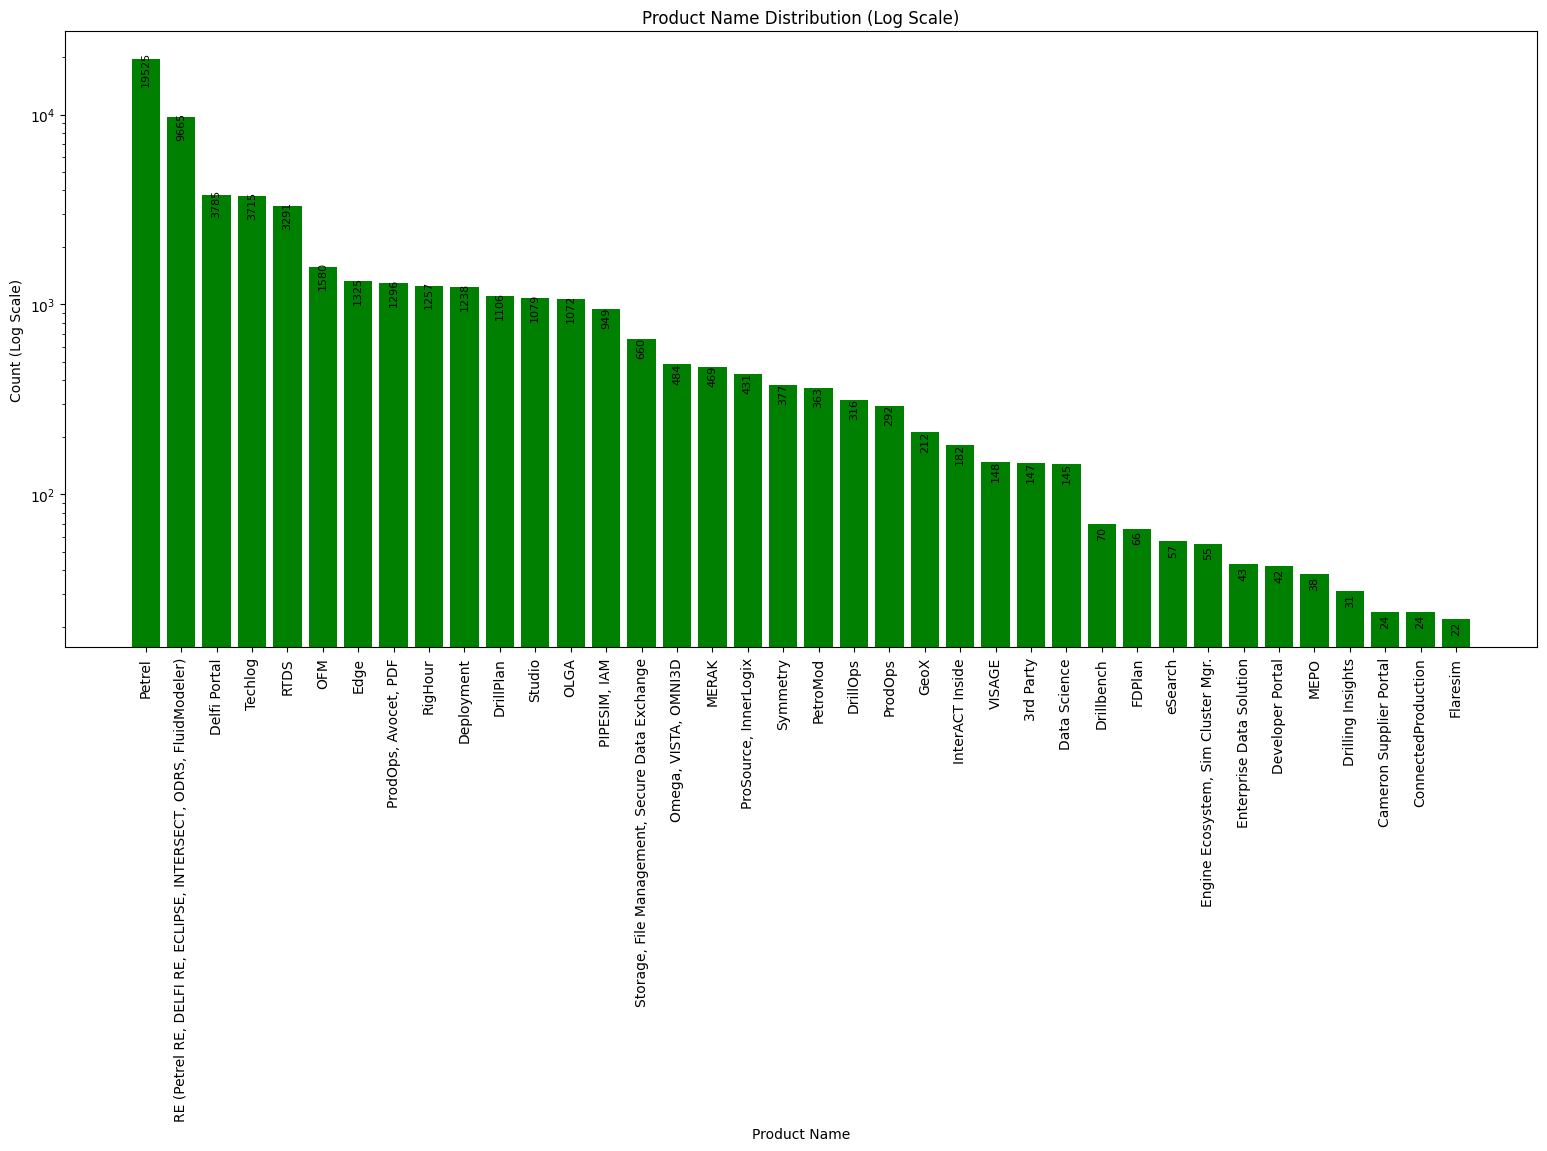

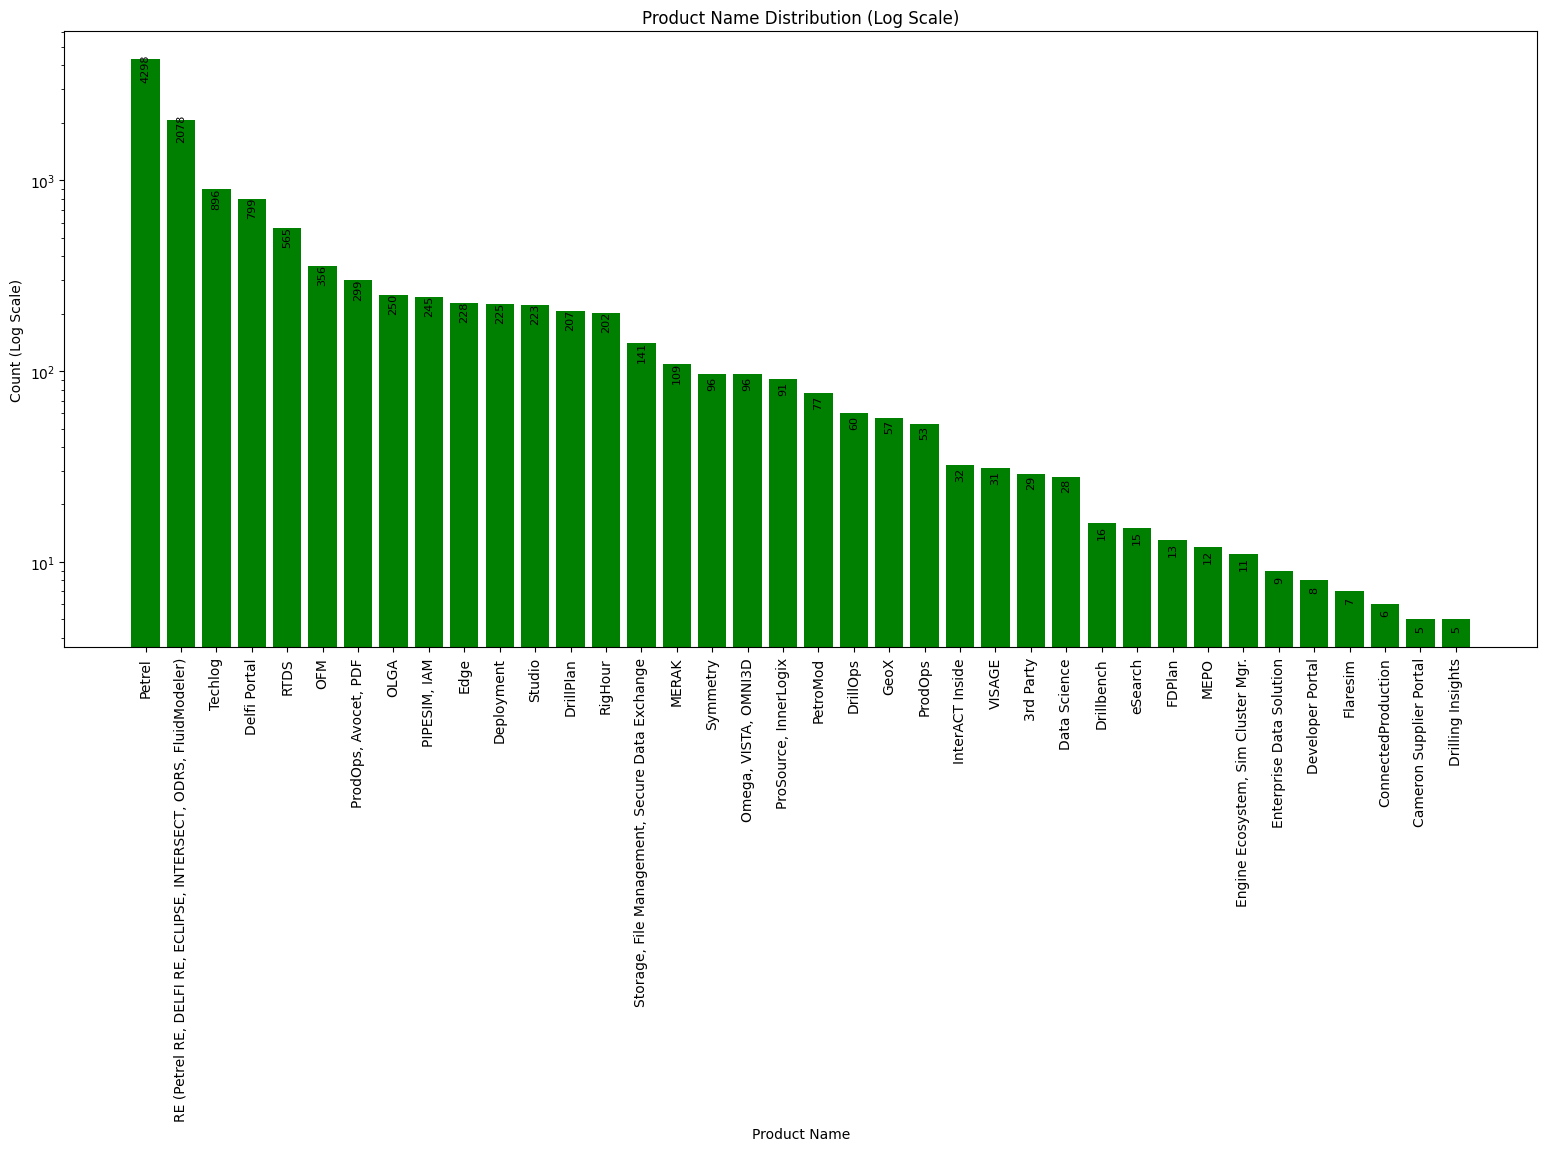

In [76]:
hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_test, 'Product Name', top=None, log=True, horizontal=True)

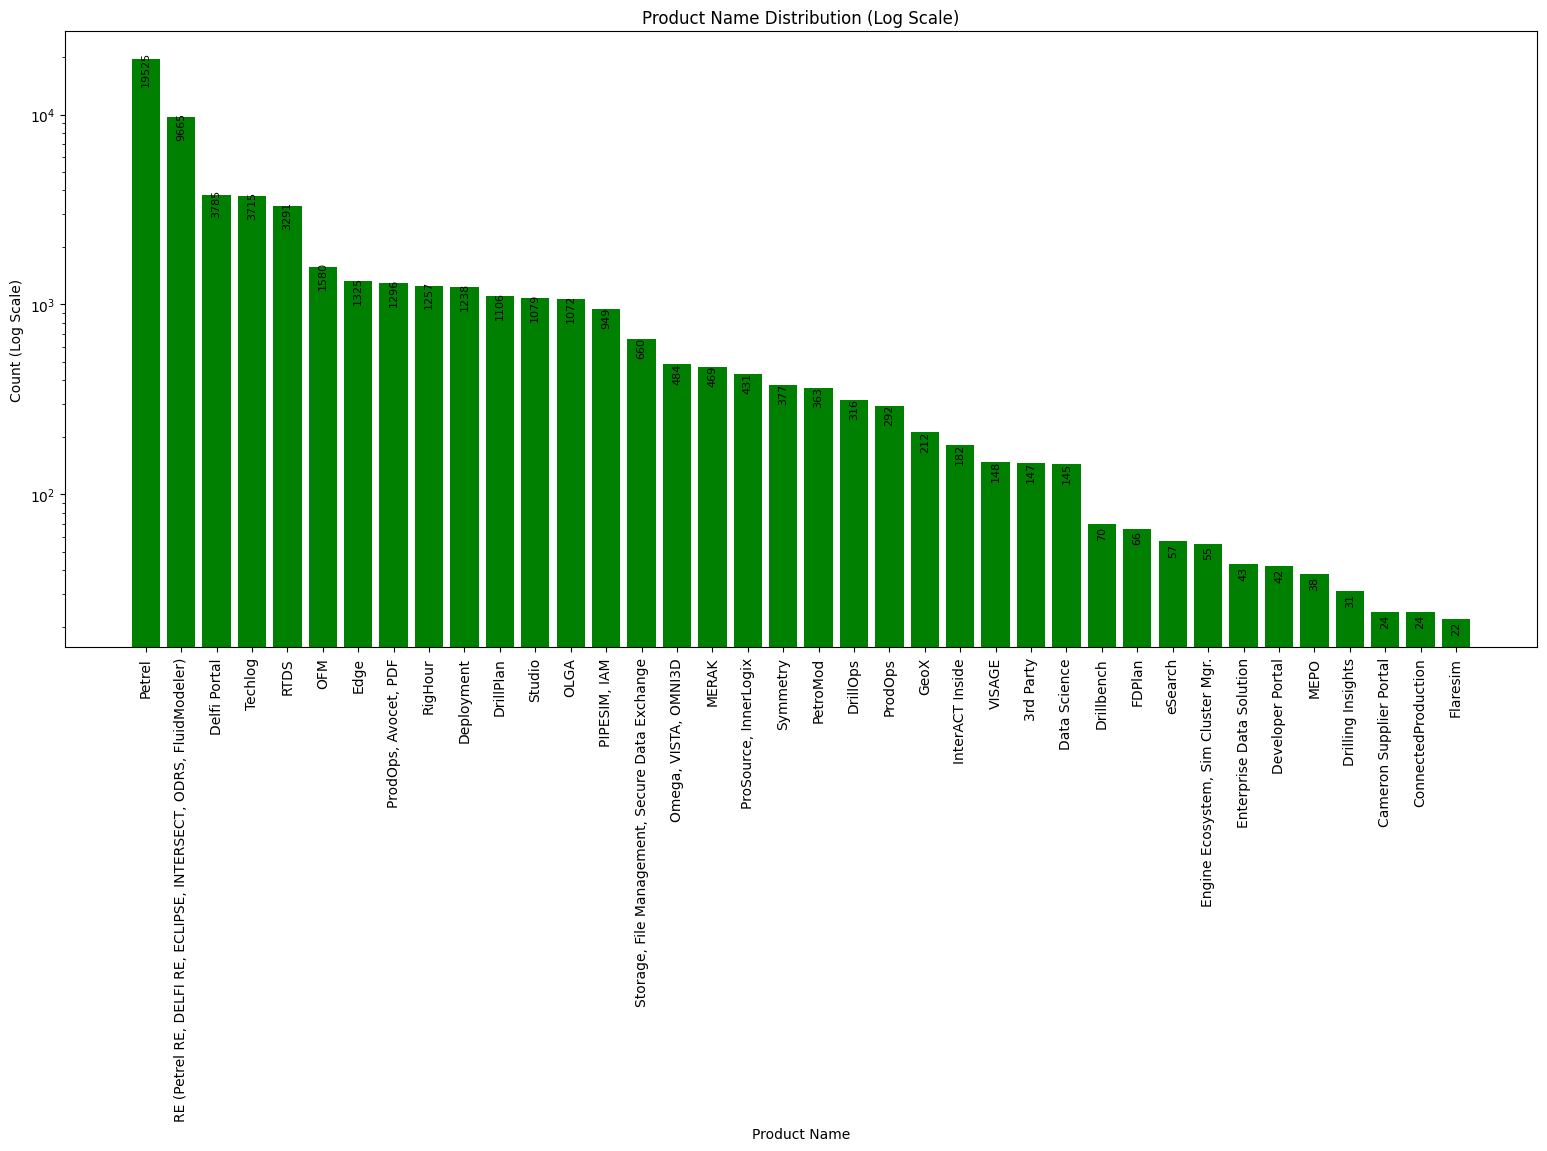

In [77]:
# Keep the top 50 products and combine the rest into 'Others'
product_counts = df_train['Product Name'].value_counts()
cutoff = 0
product_top = product_counts.index[product_counts >= cutoff]
product_others = product_counts.index[product_counts < cutoff]

mask_others = df_train['Product Name'].isin(product_others)
df_train.loc[mask_others,'Product Name']='Long Tail'
hist_by_labels(df_train, 'Product Name', log=True)

## Balance Train Data

<class 'pandas.core.frame.DataFrame'>
Index: 25600 entries, 74139 to 104163
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        25600 non-null  int64 
 1   Title             25600 non-null  object
 2   Product Name      25600 non-null  object
 3   Length            25600 non-null  int64 
 4   Language          25600 non-null  object
 5   Title_Processed   25600 non-null  object
 6   Title_Translated  25600 non-null  object
 7   Title_Cleaned     25600 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.8+ MB
None


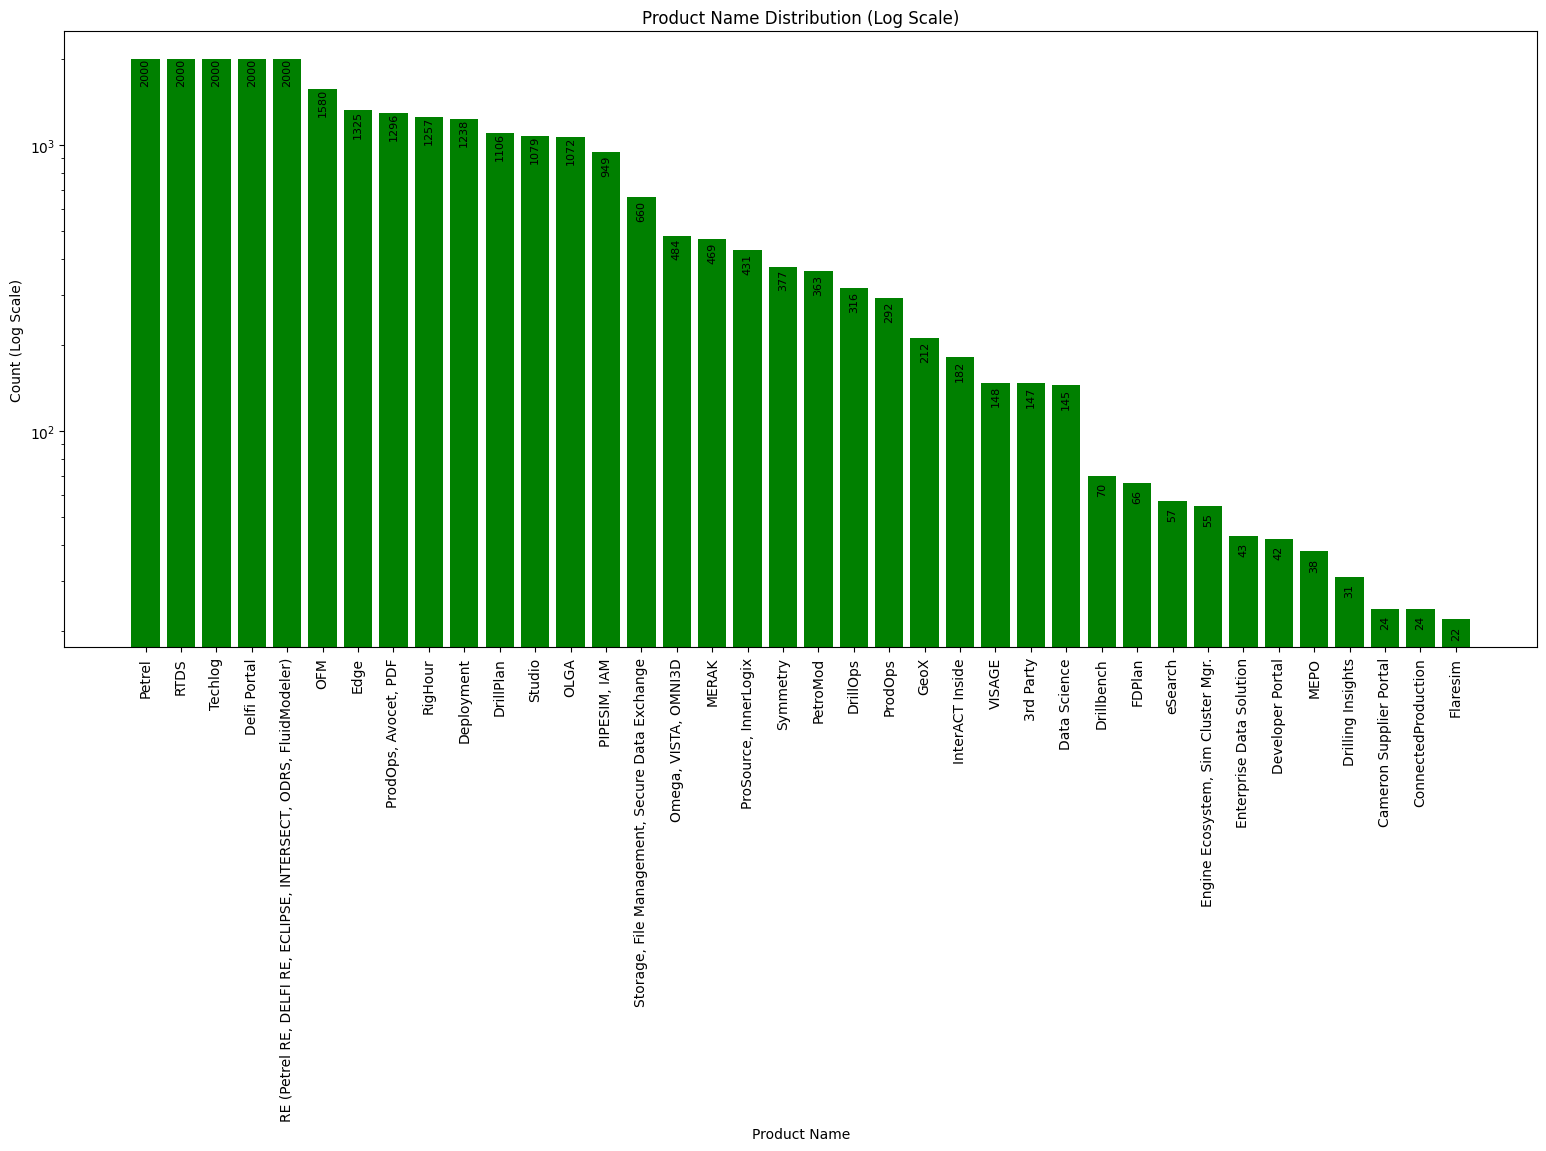

In [78]:
# for the products with more than 5000 records, randomly select 4000 records for each product and put in a new dataframe df_cleaned_balanced, then keep the rest of the records in df_cleaned_test
max_size = 2000

df_train_balanced = pd.DataFrame()

for product in df_train['Product Name'].unique():
    df_product = df_train[df_train['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_train_balanced = pd.concat([df_train_balanced, df_product_balanced])

print(df_train_balanced.info())


hist_by_labels(df_train_balanced, 'Product Name', log=True)

In [79]:
# Prepare data for training and testing for 
# a. cross validation
# b. logistic regression, 
# c. SGC Classifier

#import packages related to data
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer

column_name = 'Title_Cleaned'

X = df_train[column_name]
vectorizer = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer.fit(X)

X_train = df_train_balanced[column_name]
X_train_encoded = vectorizer.transform(X_train)
y_train = df_train_balanced['Product Name']

X_test = df_test[column_name]
X_test_encoded = vectorizer.transform(X_test)
y_test = df_test['Product Name']

# Train Models

## Model Baseline - Cross Validation

In [80]:
# Model Tuning
from sklearn.model_selection import cross_validate

# Models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [81]:
models = {
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    # 'SVC linear': SVC(kernel='linear'),
    # 'SVC rbf': SVC(kernel='rbf'),
    'MultinomialNB': MultinomialNB(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'XGBClassifier': xgb.XGBClassifier()
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        X_train_encoded, # please provide the features after preprocessing
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.8118 by SGDClassifier.
Average score: 0.8064 by LogisticRegression.
Average score: 0.7714 by MultinomialNB.


In [ ]:
# Baseline Score(s) of each model are ....
# Average score: 0.8292 by SGDClassifier.
# Average score: 0.8229 by LogisticRegression.
# Average score: 0.7911 by MultinomialNB.

# Baseline Score(s) of each model are ....
# Average score: 0.8570 by SVC linear.
# Average score: 0.8558 by LogisticRegression.
# Average score: 0.8534 by SGDClassifier.
# Average score: 0.8475 by SVC rbf.
# Average score: 0.8183 by MultinomialNB.

## Hpyerparameter Tuning

## SGC Classifier

In [82]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=50, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-21 12:52:54,166] A new study created in memory with name: no-name-de890dc4-73d7-4e81-bb7b-128b05fe0415


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-21 12:52:56,423] Trial 3 finished with value: 0.11968749999999999 and parameters: {'loss': 'modified_huber', 'alpha': 13.4730830753594, 'penalty': 'l2'}. Best is trial 3 with value: 0.11968749999999999.
[I 2023-10-21 12:52:57,430] Trial 8 finished with value: 0.02578125 and parameters: {'loss': 'modified_huber', 'alpha': 9.296771271795713, 'penalty': 'l1'}. Best is trial 3 with value: 0.11968749999999999.
[I 2023-10-21 12:52:57,539] Trial 7 finished with value: 0.7983984375000001 and parameters: {'loss': 'log_loss', 'alpha': 9.94820785866363e-06, 'penalty': 'l2'}. Best is trial 7 with value: 0.7983984375000001.
[I 2023-10-21 12:52:57,668] Trial 2 finished with value: 0.078125 and parameters: {'loss': 'log_loss', 'alpha': 0.875666345541993, 'penalty': 'l1'}. Best is trial 7 with value: 0.7983984375000001.
[I 2023-10-21 12:52:57,723] Trial 5 finished with value: 0.078125 and parameters: {'loss': 'log_loss', 'alpha': 0.9505501426125924, 'penalty': 'l1'}. Best is trial 7 with va

/Users/haitao/.pyenv/versions/3.12.0/envs/haitao/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haitao/.pyenv/versions/3.12.0/envs/haitao/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haitao/.pyenv/versions/3.12.0/envs/haitao/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.286     0.138     0.186        29
                                         Cameron Supplier Portal      0.000     0.000     0.000         5
                                             ConnectedProduction      0.000     0.000     0.000         6
                                                    Data Science      0.800     0.429     0.558        28
                                                    Delfi Portal      0.614     0.771     0.684       799
                                                      Deployment      0.610     0.667     0.637       225
                                                Developer Portal      0.000     0.000     0.000         8
                                                        DrillOps      0.774     0.683     0.726        60
                                             

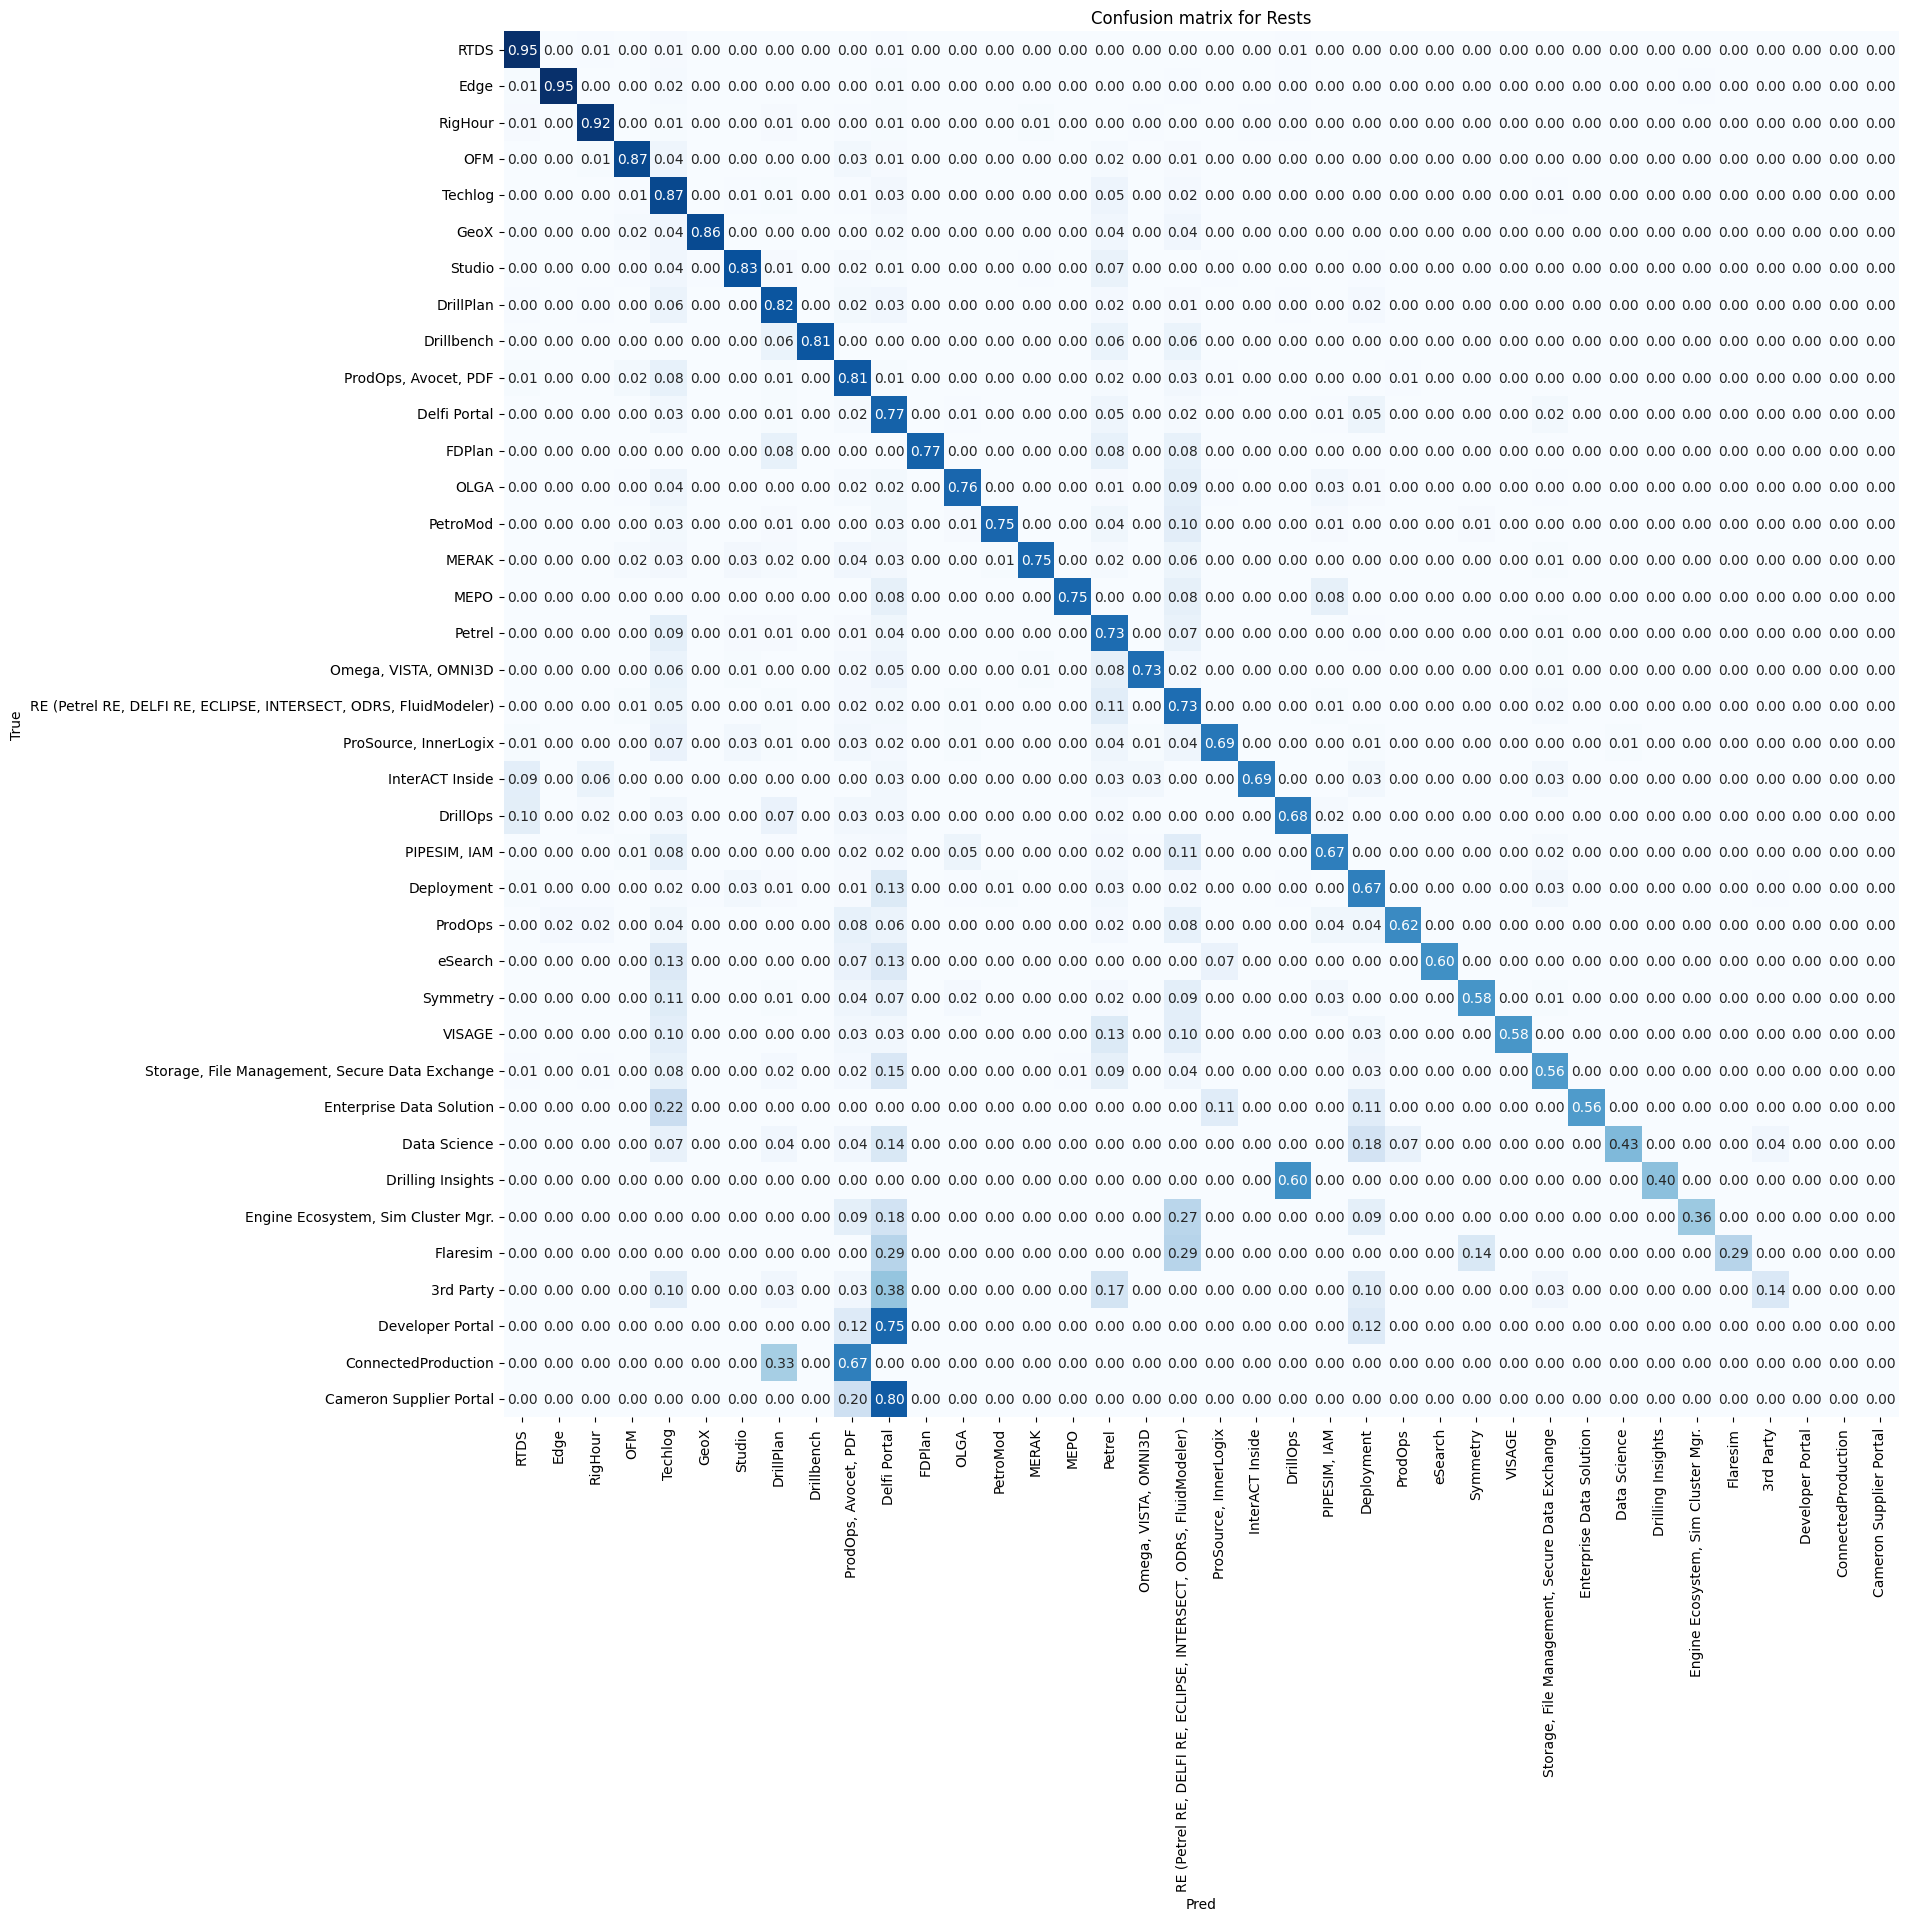

Accuracy of top 1 prediction is 0.761.
Accuracy of top 3 prediction is 0.914.
Accuracy of top 5 prediction is 0.950.


In [83]:
# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_encoded)
# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
import pickle
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))


## Logistic Classification

In [84]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'sag']),
        'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=25, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-21 12:53:45,555] A new study created in memory with name: no-name-3e0438b2-17f9-42da-b808-35cedf81968b


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-10-21 12:54:03,376] Trial 5 finished with value: 0.28453125 and parameters: {'solver': 'saga', 'C': 1.1665745861769863e-05, 'penalty': 'l2'}. Best is trial 5 with value: 0.28453125.
[I 2023-10-21 12:54:04,152] Trial 7 finished with value: 0.6399609375 and parameters: {'solver': 'sag', 'C': 0.008647041579984777, 'penalty': 'l2'}. Best is trial 7 with value: 0.6399609375.
[I 2023-10-21 12:54:04,666] Trial 4 finished with value: 0.645703125 and parameters: {'solver': 'sag', 'C': 0.00923938926549046, 'penalty': 'l2'}. Best is trial 4 with value: 0.645703125.
[I 2023-10-21 12:54:22,774] Trial 2 finished with value: 0.7427343750000001 and parameters: {'solver': 'sag', 'C': 0.05684003445388754, 'penalty': 'l2'}. Best is trial 2 with value: 0.7427343750000001.
[I 2023-10-21 12:54:27,521] Trial 9 finished with value: 0.56203125 and parameters: {'solver': 'lbfgs', 'C': 0.0030024670265621795, 'penalty': 'l2'}. Best is trial 2 with value: 0.7427343750000001.
[I 2023-10-21 12:54:43,403] Tri

Accuracy: 0.764
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.308     0.138     0.190        29
                                         Cameron Supplier Portal      0.000     0.000     0.000         5
                                             ConnectedProduction      0.000     0.000     0.000         6
                                                    Data Science      0.765     0.464     0.578        28
                                                    Delfi Portal      0.601     0.773     0.676       799
                                                      Deployment      0.602     0.667     0.633       225
                                                Developer Portal      0.000     0.000     0.000         8
                                                        DrillOps      0.784     0.667     0.721        60
                             

/Users/haitao/.pyenv/versions/3.12.0/envs/haitao/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haitao/.pyenv/versions/3.12.0/envs/haitao/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haitao/.pyenv/versions/3.12.0/envs/haitao/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

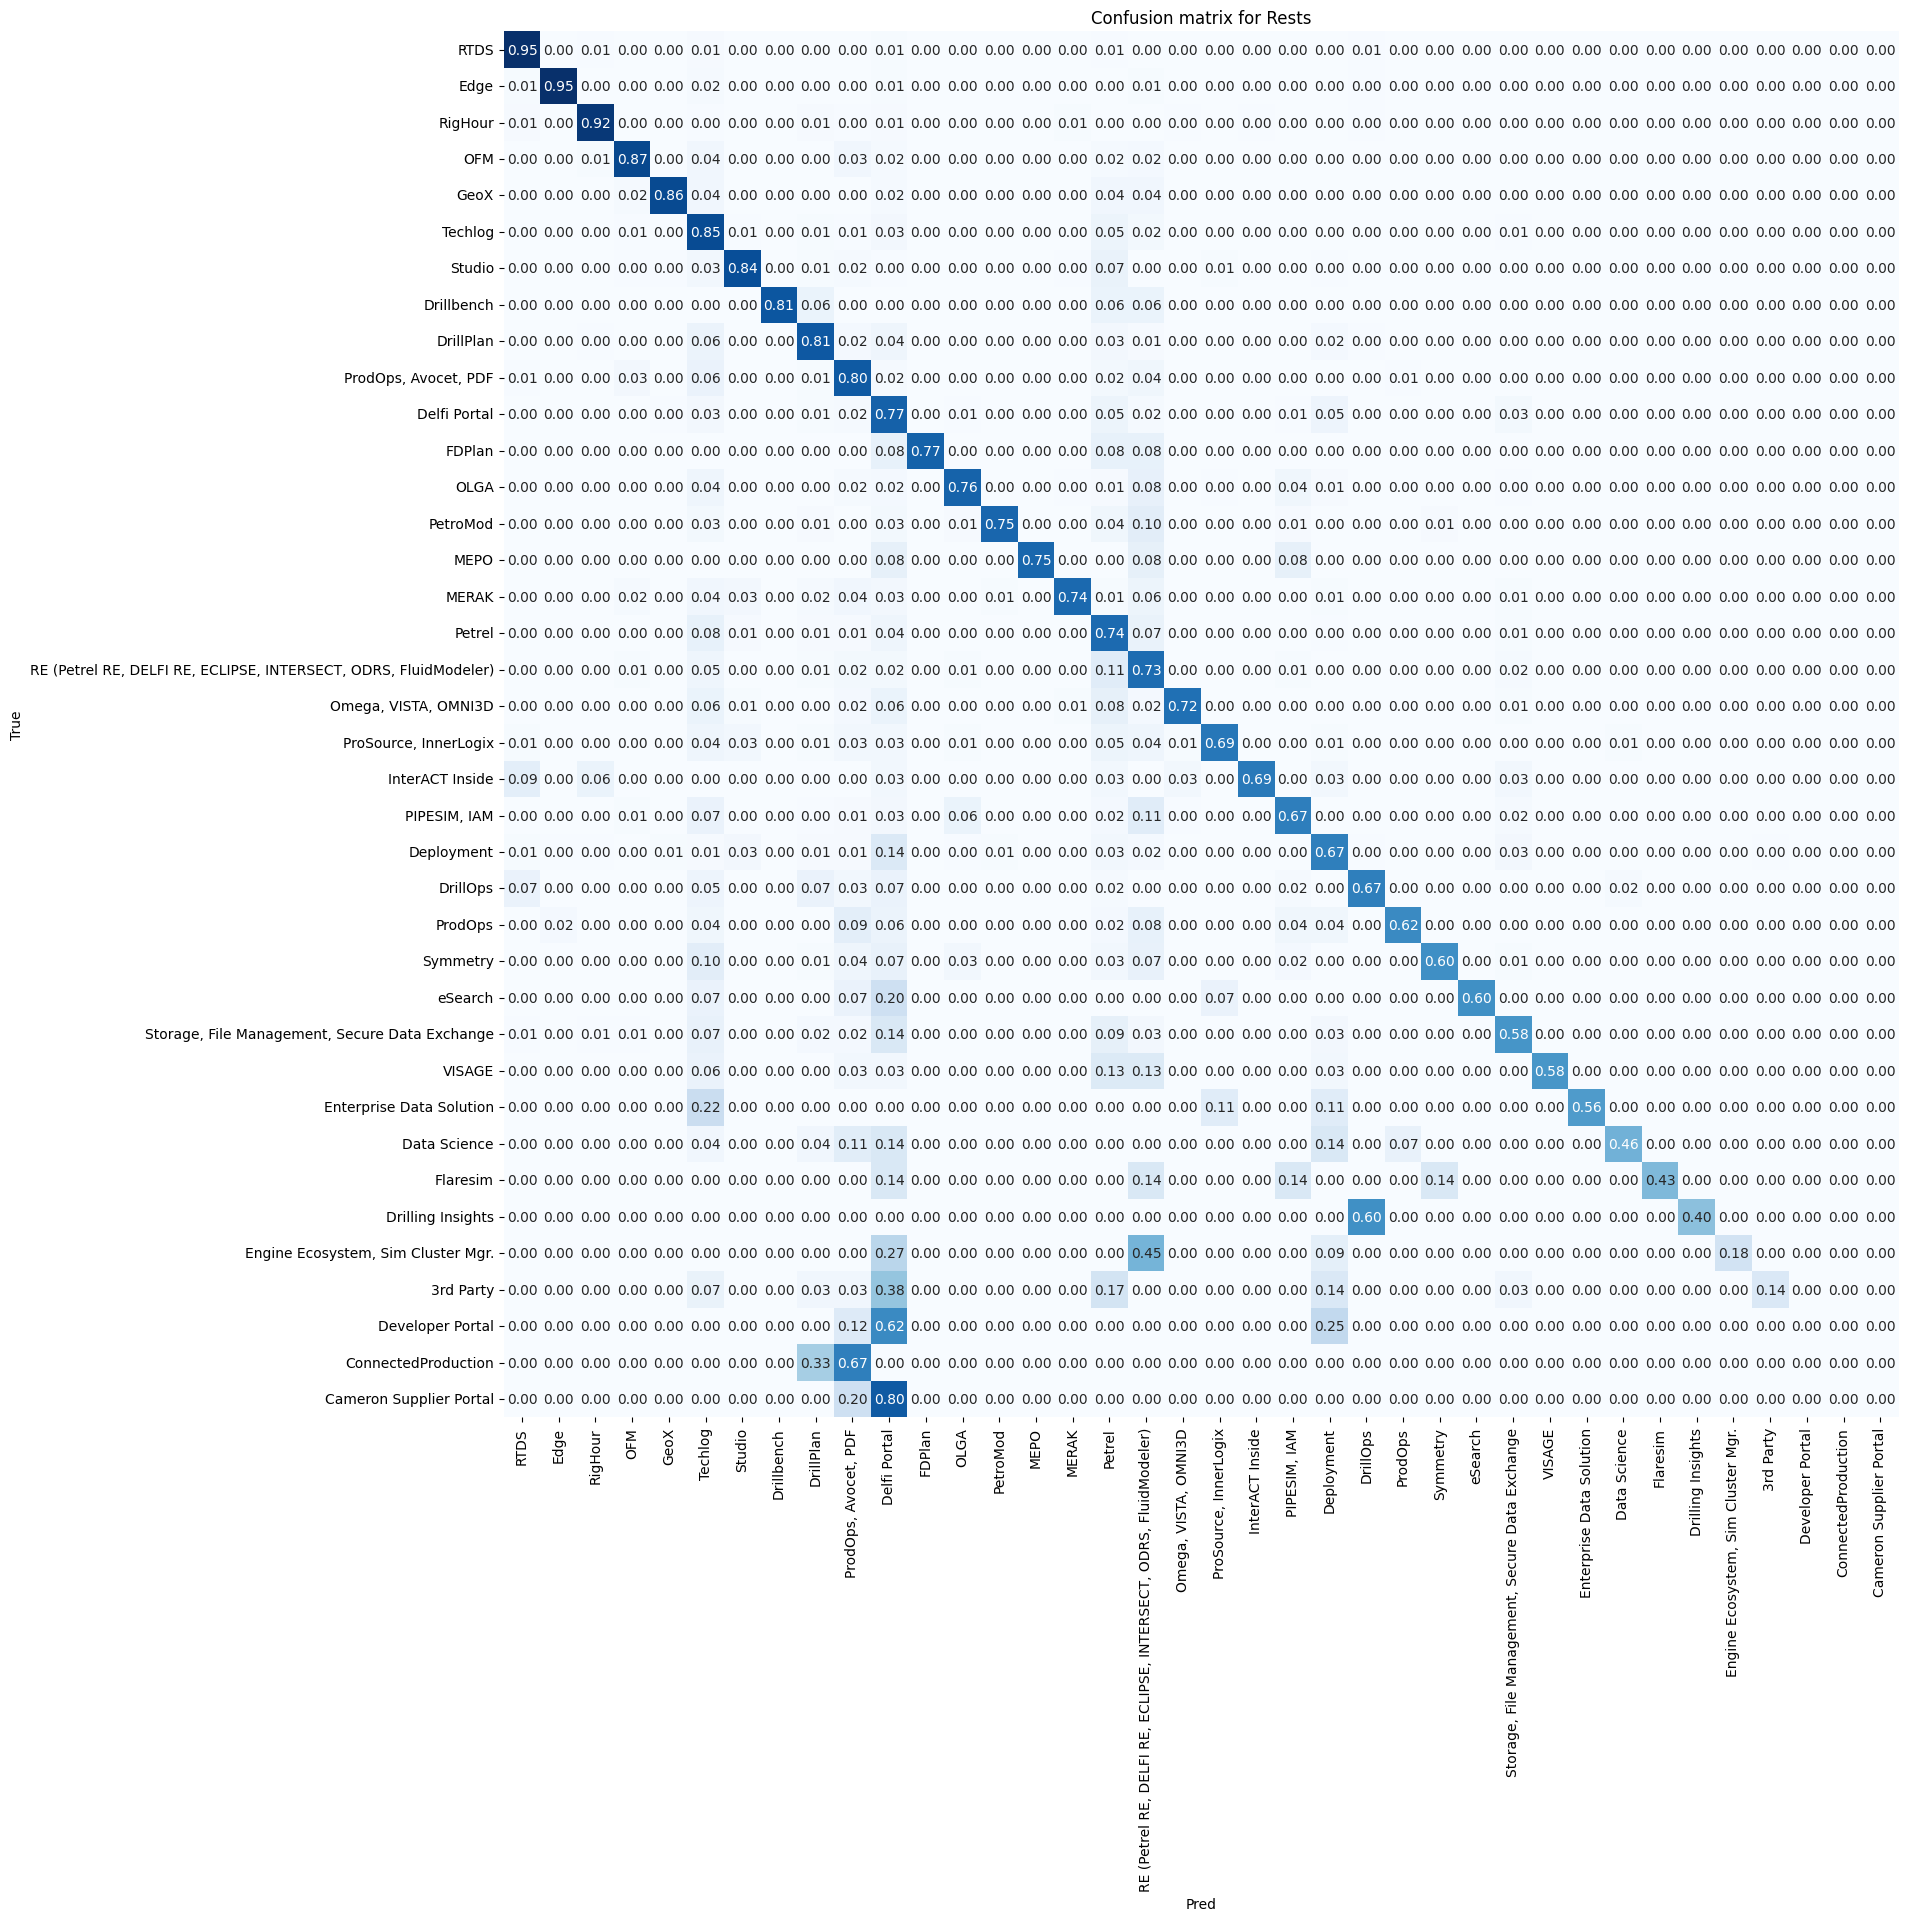

Accuracy of top 1 prediction is 0.764.
Accuracy of top 3 prediction is 0.913.
Accuracy of top 5 prediction is 0.951.


In [85]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(**best_params)
best_model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# Create and train the best Logistic Regression model
model_logReg= LogisticRegression(max_iter=5000)
model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(model_logReg, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
import pickle
pickle.dump(model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB

In [86]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-21 12:58:53,095] A new study created in memory with name: no-name-9200f69c-105e-4969-a1e6-f14270966ea9


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2023-10-21 12:58:54,974] Trial 2 finished with value: 0.7909375000000001 and parameters: {'alpha': 0.1974717749964307, 'fit_prior': True}. Best is trial 2 with value: 0.7909375000000001.
[I 2023-10-21 12:58:55,200] Trial 1 finished with value: 0.7804296875000001 and parameters: {'alpha': 0.6186029152194912, 'fit_prior': True}. Best is trial 2 with value: 0.7909375000000001.
[I 2023-10-21 12:58:55,307] Trial 8 finished with value: 0.7513671874999999 and parameters: {'alpha': 0.00019303936683795166, 'fit_prior': True}. Best is trial 2 with value: 0.7909375000000001.
[I 2023-10-21 12:58:55,309] Trial 5 finished with value: 0.751328125 and parameters: {'alpha': 0.0002008518201332692, 'fit_prior': True}. Best is trial 2 with value: 0.7909375000000001.
[I 2023-10-21 12:58:55,363] Trial 9 finished with value: 0.7526953125 and parameters: {'alpha': 2.30193000521261, 'fit_prior': True}. Best is trial 2 with value: 0.7909375000000001.
[I 2023-10-21 12:58:55,375] Trial 0 finished with value: 0

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear

In [ ]:
# user Optuna to tune the hyperparameters for SVC Linear

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', **best_params)
best_model_svc_linear.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:

pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))


## Voting model

In [ ]:
# now we have three models, logistic regression, multinomialNB and svc_linear, we can use voting classifier to combine them together
from sklearn.ensemble import VotingClassifier

# Create a dictionary of the models
estimators = [
    ('logReg', best_model_logReg),
    ('sgc_classifier', best_model_sgc),
    ('multinomialNB', best_model_multinomialNB)
]

# Create a voting classifier
voting = VotingClassifier(estimators, voting='soft')

# Fit the voting classifier to the training data
voting.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')
df_pred_top5_voting = top5_accuracy_report(voting, vectorizer, X_test, y_test, pre_processed=True)
